<a href="https://colab.research.google.com/github/GabeXxX/NAPDE-Coursework/blob/main/Vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

# TODO
- [x] preprocessing the data and shuffling it (How? search, not copy)
- [x] Define the encoder network
- [x] Define the decoder network  
- [ ] Understand Convolution and traspose Convolution parameters
- [x] implement the reparameterization trick
- [ ] define the loss function and the optimizer (what is an optimzer in keras? search, not copy)
- [ ] train the network
- [ ] generate image
- [ ] finish and integrate blog post on theory    

# Load and pre-process data
Each MNIST image is originally a vector of 28x28 integers, each of which is between 0-255 and represents the intensity of a pixel. We Model each pixel with a Bernoulli distribution in our model, first normalizing(helping the gradient calculations to stay consistent, and not get so large so that they slow down or prevent a network to converge) and then binarizing each images.

Then we shuffle the data, ensuring that each batch contains a different mix of data, which helps the model to learn from different patterns in each epoch.

In [2]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Discard label as we don't use it
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
type(x_train)

numpy.ndarray

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
# Normalize
x_train = x_train / 255
x_test = x_test / 255

In [6]:
# Reshape to include the color channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [7]:
# Binarize
def binarize_images(images):
  return np.where(images > 0.5, 1.0, 0.0).astype('float32')

In [8]:
x_train = binarize_images(x_train)
x_test = binarize_images(x_test)

In [9]:
# Visualizing
def visualize_binary_vectors(dataset, width, height, num_vectors=8):
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))

    for i in range(num_vectors):
        binary_vector = dataset[i, :,:,0]
        binary_matrix = np.array(binary_vector).reshape((height, width))

        # Plot each binary image as a subplot
        n = np.ceil(num_vectors/2).astype(int)
        ax = axes[i // n, i % n]
        ax.imshow(binary_matrix)
        ax.set_title(f'Image {i + 1}')

    plt.tight_layout()
    plt.show()

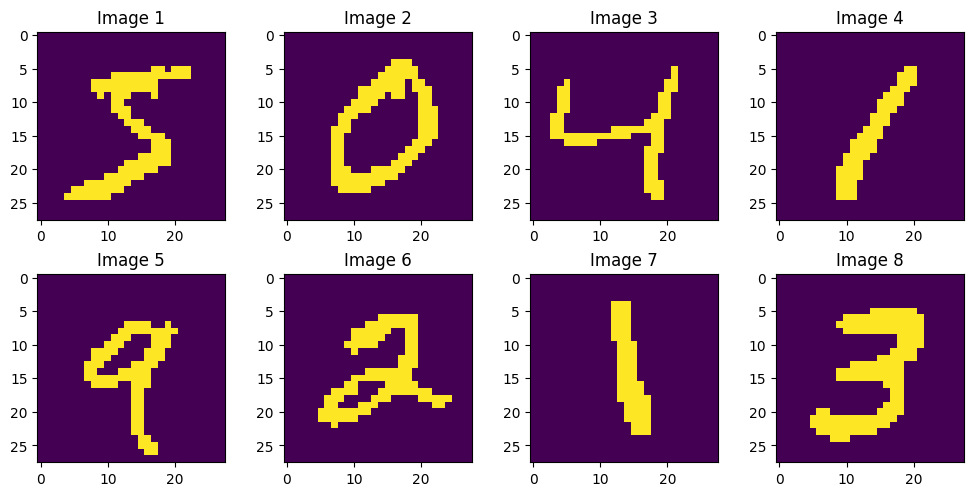

In [10]:
visualize_binary_vectors(x_train, 28, 28)

In [11]:
# define some useful variable
train_size = x_train.shape[0]
test_size = x_test.shape[0]
batch_size = 32

In [12]:
# Shuffle the data
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(train_size)
test_data = tf.data.Dataset.from_tensor_slices(x_test).shuffle(test_size)

# Batch the data
train_data = train_data.batch(batch_size)
test_data = test_data.batch(batch_size)

# Define the network
We need to define the encoder, the decoder, the reparametrization trick, the loss function and the optimizer.

Which input shape the network accept? We define as input shape the shape of a single image, i.e. a 28x28 image.

What's the rational behind the deep/filter return from a single Convolutional layer?
Convolutional layers with multiple filters allow the network to learn a diverse set of features from the input data. Each filter specializes in detecting different patterns or features within the input image. A deeper network with more filters can capture more complex and abstract features, enabling better representation learning.

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$
\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].
$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:
$$
\log p(x| z) + \log p(z) - \log q(z|x)
$$


where $z$ is sampled from $q(z|x)$.

In [13]:
class ConvolutionalVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.Input(shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                                       activation="relu"),
                tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                                       activation="relu"),
                tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                                       activation="relu"),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=latent_dim + latent_dim)  # No activation function in this layer
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation="relu"),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean # return z, our latent vector

    def decode(self, z, apply_sigmoid=False):
      logits = self.decoder(z)
      if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
      return logits

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)


In [14]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))



What we are doing here?
We are defining a new model inherithing from the Model class in keras:
- `encoder` and `decoder` function define thorugh the keras seequential api the encoder and the decoder part of the vae

The main method are the `compute_loss` method and the `train_step` method:
- `compute_loss`: use the `encode` function to obatain the latent distribution parameter from the `encoder`, ande the `decode` function to obtain the reconstructed data distribution from the `decoder`, the return the loss to be optimized (how this loss is computed in detail? TODO)
- `train_step` this function will be inserted in a for loop later that represent our train process on the train data for the prestabilited epoch, and allow to update the weight of our model (defined by the previous class) in the for loop dedicated to the train

In [15]:
epochs = 10
latent_dim = 2 # set the dimensionality of the latent space to a plane for visualization later
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = ConvolutionalVAE(latent_dim)

In [16]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [17]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_data.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :,:]

Epoch: 10, Test set ELBO: -152.72824096679688, time elapse for current epoch: 6.227118015289307


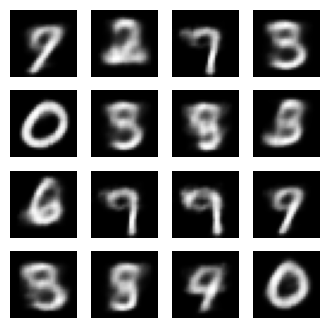

In [19]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_data:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_data:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [20]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

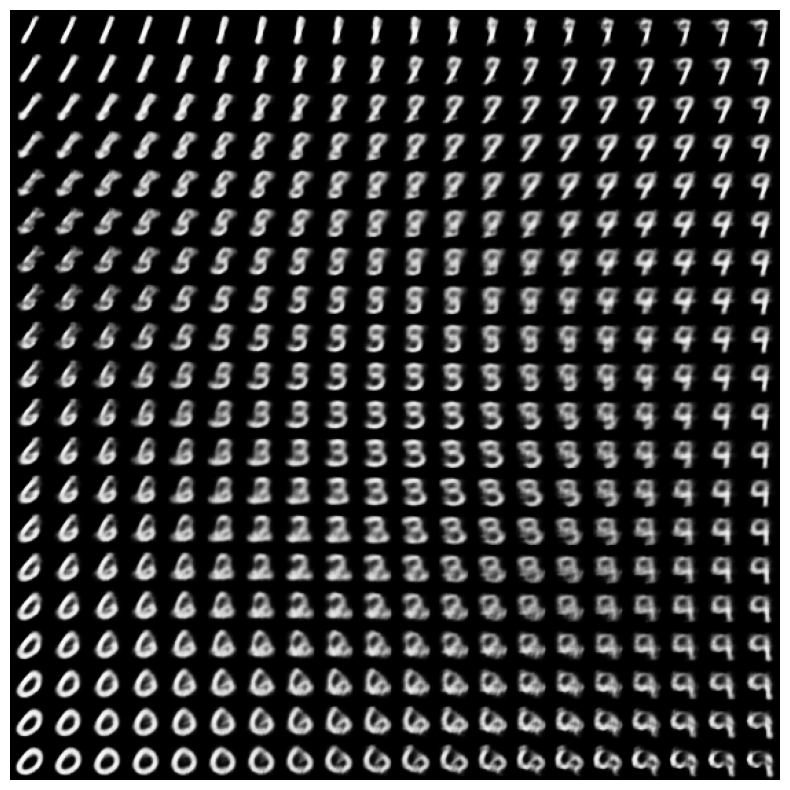

In [23]:
plot_latent_images(model, 20)

# What we have done
1. We have preprocessed the images. The important thing to note here is that we have reshaped the image to include a color channel, that was not present in the original dataset as there were only grey-scale images. But Keras require as correct format a tensor with also the color channel dimension (that in this case was only one as there were only the gray channel).

2. We have shuffled the data, to ensure that the network learn different pattern in each epoch. Then we batched the data. In this way the batched gradient descent compute the gradient of the loss function wrt the parameter using the samples in the current batch instead of a simple batch. In each epoch all the batch are scanned and the weight updates after each batch pass.

3. We define the vae network and all the facilities for training it. The important things here are the `compute_loss` function and the `train_step` function. The first is used in the second anf allow to compute the loss function. In the second we compute the gradient on such loss function and we upadte the parameter of our neural network according to such gradient

4. The `train_step` function is the used in the proper train loop that iterate over all the batch samples and epoch. In the train loop after the training on each images we compute the loss also on the test data and we generate a sample from the decoder to visualized what our netowrk is learning. Here we compute the mean and variance to which or test sample is mapped from our encoder, generate the latent vector and map this to the reconstructed image via the decoder.


# Sources
1. https://www.tensorflow.org/tutorials/generative/cvae
2. https://keras.io/examples/generative/vae/
3. https://mbernste.github.io/posts/vae/
4. https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing